# Assignment - Support Vector Classification


## Authors
V. Aquiviva and B.W. Holwerda

## Learning Goals
* introducton to Support Vector Classification
* the importance of data preparation (features and labels)
* How to define and benchmark success of a classifier

## Keywords
python, syntax, jupyter notebook, XVN, scikit-learn, SVC

## Companion Content
Chapter 4 of the Machine Learning for Physics and Astronomy by Viviana Acquaviva

## Summary
The accompanying notebook illustrates the full cleaning process that needed to happen to make the training set.

<hr>


## Student Name and ID: YOUR NAME HERE (ID NUMBER)


## Date: 

<hr>

In [155]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=False)

from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

### Learning Curve Plot

We will need this function later, when we plot the learning curve. 

In [156]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("# of training examples",fontsize = 14)
 
    plt.ylabel("Accuracy score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    plt.legend(loc="best",fontsize = 12)
    return plt

## Prepared Data

The accompanying notebook shows how the feature and label data was extracted from the simulation output. You can run through the steps to get a feeling for what needed to be done to *prepare* data. This is an oft overlooked step of data science: the cleaning and inspection of your sample. 

Read in features and labels.

In [55]:
features = pd.read_csv('ParticleID_features.csv', index_col='ID')

In [56]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
features.shape

(5000, 67)

In [58]:
y = np.genfromtxt('ParticleID_labels.txt', dtype = str)

In [59]:
y

array(['ttbar', 'ttbar', 'ttbar', ..., 'ttbar', '4top', 'ttbar'],
      dtype='<U5')

### We need to turn categorical (string-type) labels into an array, e.g. 0/1.

we are not quite done with preparing the data, the label needs to be inverted.

In [61]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() #turns categorical into 1 ... N

In [62]:
y

array(['ttbar', 'ttbar', 'ttbar', ..., 'ttbar', '4top', 'ttbar'],
      dtype='<U5')

In [63]:
y = le.fit_transform(y)

In [64]:
y #This uses 1 for the first instance, I actually wanted  4top to be my positive label.

array([1, 1, 1, ..., 1, 0, 1])

In [65]:
target = np.abs(y - 1)

In [66]:
target # Happier now.

array([0, 0, 0, ..., 0, 1, 0])

### Looking for 4top

The labels have now been defined as positive for a '4-top' particle and negative for anything else. We are looking for 4-top particles and are not interested in the others.

## Feature Inspection

Let's take a look at these features, using the "describe" property.

In [74]:
features.describe() #Note that this automatically excludes non-numerical type columns

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4.950000e+03,4950.000000,4950.000000,4950.000000,4.717000e+03,4717.000000,4717.000000,4717.000000,4.002000e+03,4002.000000,4002.000000,4002.000000,2.871000e+03,2871.00000,2871.000000,2871.000000,1.889000e+03,1889.000000,1889.000000,1889.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,7.290000e+02,729.000000,729.000000,729.000000,4.420000e+02,442.000000,442.000000,442.000000,2.610000e+02,261.000000,261.000000,261.000000,1.270000e+02,127.000000,127.000000,127.000000,5.600000e+01,56.000000,56.000000,56.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.527799e+05,1.080302e+05,-0.029936,0.007327,2.117980e+05,74863.343131,-0.025104,0.011845,1.805997e+05,57289.049481,0.010723,0.045266,1.780366e+05,48798.018516,0.015167,-0.031312,1.705620e+05,44042.67015,-0.022948,0.014522,1.628825e+05,41151.069666,0.002228,0.006738,1.581409e+05,40250.387015,0.072349,-0.035907,1.596814e+05,40139.289849,0.061654,-0.045868,1.574039e+05,39703.038235,0.118543,0.024249,1.561160e+05,38173.716092,0.029455,0.026422,1.631051e+05,34876.849606,0.206978,-0.001085,1.456600e+05,36151.183929,-0.000879,0.219260
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638580e+05,8.136261e+04,1.439105,1.828832,2.510361e+05,46309.512365,1.577316,1.802715,2.383403e+05,32013.857623,1.634072,1.812078,2.577958e+05,26252.978520,1.744489,1.784248,2.381745e+05,23510.65367,1.806611,1.811101,2.269341e+05,20988.953157,1.815312,1.771888,2.118782e+05,26556.025657,1.836492,1.796932,2.308620e+05,30074.756789,1.842798,1.788596,2.165489e+05,30502.312276,1.872084,1.826435,2.319016e+05,29324.658352,1.884750,1.753017,2.248603e+05,20433.767238,1.998859,1.949004,1.943657e+05,25861.883410,1.941707,1.910400
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,1.087540e+04,1.080000e+04,-4.668790,-3.140530,1.221050e+04,10639.800000,-4.520250,-3.141480,1.169190e+04,10818.000000,-4.616550,-3.136130,1.110310e+04,10287.000000,-4.778980,-3.139040,1.070330e+04,10066.90000,-4.930230,-3.140380,1.197700e+04,11260.200000,-4.758150,-3.135630,1.380860e+04,10973.300000,-4.606330,-3.132610,1.119760e+04,10067.900000,-4.814380,-3.136380,1.615530e+04,10183.700000,-4.803880,-3.135910,2.004750e+04,14800.200000,-4.400470,-3.130690,1.780380e+04,12987.900000,-4.447660,-3.139820,2.512510e+04,14836.000000,-4.448760,-2.990730
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007510e+05,6.321840e+04,-1.060500,-1.602460,7.636905e+04,46549.475000,-1.125620,-1.547417,5.999090e+04,36097.700000,-1.121240,-1.518030,5.278370e+04,30891.650000,-1.198468,-1.550615,5.007050e+04,28453.95000,-1.250050,-1.586675,4.695560e+04,27963.500000,-1.231420,-1.475380,4.535515e+04,27140.550000,-1.243963,-1.626687,4.387110e+04,26825.000000,-1.226980,-1.513330,4.410735e+04,26589.250000,-1.223240,-1.422415,4.092160e+04,25298.300000,-1.413650,-1.270700,4.365005e+04,24742.500000,-1.259230,-1.817600,4.112588e+04,24974.125000,-1.243362,-1.490900
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.659740e+05,8.584360e+04,-0.057428,0.015111,1.288565e+05,62498.400000,-0.040648,0.034238,9.922610e+04,48949.200000,-0.035512,0.060279,9.206885e+04,41054.850000,0.054393,-0.079641,8.593460e+04,37378.30000,-0.046667,0.040528,7.975460e+04,34681.700000,0.025305,0.046141,8.315485e+04,33683.550000,0.156083,-0.015617,7.894980e+04,33328.000000,0.072709,-0.052590,7.609735e+04,30942.700000,0.035675,0.090282,7.568430e+04,29479.700000,-0.088908,-0.041002,8.050910e+04,28262.800000,0.120301,-0.232455,9.553645e+04,27353.550000,-0.121213,0.128103
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.9999

### Exercise 1

Looking at the "count" row, does every column of the features have an equal number of entries?

Knowning what you know from particle collissions, why would some columns be missing? 


* student answer here*

### Important:

Looking at the "count" row, we can see that the whole data set has 5,000 rows, but some columns are present only for a fraction of them. We can now explore two options: only consider the first products (for which there are 5000 entries), or replace them with 0 or another dummy value.

#### Option 1: Only consider first 16 columns (first four products) so we have limited imputing/manipulation problems.

In [75]:
features_lim = features[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16']]

In [76]:
features_lim.head()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
ID,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,137571.0,128444.0,-0.345744,-0.307112,174209.0,127932.0,0.826569,2.332000,86788.9,84554.9,-0.180795,2.187970,140289.0,76955.8,-1.19933,-1.302800
1,57594.2,-0.509253,161529.0,80458.3,-1.318010,1.402050,291490.0,68462.9,-2.126740,-2.582310,44270.1,35139.6,-0.706120,-0.371392,72883.9,26902.2,-1.65386,-3.129630
2,82313.3,1.686840,167130.0,113078.0,0.937258,-2.068680,102423.0,54922.3,1.226850,0.646589,60768.9,36244.3,1.102890,-1.434480,77714.0,27801.5,1.68461,1.389690
3,30610.8,2.617120,112267.0,61383.9,-1.211050,-1.457800,40647.8,39472.0,-0.024646,-2.222800,201589.0,32978.6,-2.496040,1.137810,90096.7,26964.5,1.87132,0.817631
4,45153.1,-2.241350,178174.0,100164.0,1.166880,-0.018721,92351.3,69762.1,0.774114,2.568740,61625.2,50086.7,0.652572,-3.012800,104193.0,31151.0,1.87641,0.865381


In [77]:
features_lim.describe() #This automatically excludes non-numerical type columns, and missing values/NaNs are not counted.

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4.950000e+03,4950.000000,4950.000000,4950.000000,4.717000e+03,4717.000000,4717.000000,4717.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.527799e+05,1.080302e+05,-0.029936,0.007327,2.117980e+05,74863.343131,-0.025104,0.011845,1.805997e+05,57289.049481,0.010723,0.045266
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638580e+05,8.136261e+04,1.439105,1.828832,2.510361e+05,46309.512365,1.577316,1.802715,2.383403e+05,32013.857623,1.634072,1.812078
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,1.087540e+04,1.080000e+04,-4.668790,-3.140530,1.221050e+04,10639.800000,-4.520250,-3.141480,1.169190e+04,10818.000000,-4.616550,-3.136130
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007510e+05,6.321840e+04,-1.060500,-1.602460,7.636905e+04,46549.475000,-1.125620,-1.547417,5.999090e+04,36097.700000,-1.121240,-1.518030
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.659740e+05,8.584360e+04,-0.057428,0.015111,1.288565e+05,62498.400000,-0.040648,0.034238,9.922610e+04,48949.200000,-0.035512,0.060279
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999950e+05,1.238700e+05,1.028340,1.605210,2.421225e+05,89587.500000,1.066302,1.570887,1.914340e+05,68782.100000,1.159480,1.612220
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,2.800410e+06,788338.000000,4.798090,3.139020,2.503590e+06,481884.000000,4.730480,3.139660


### Option 2; replace bad values

There are still some feature columns with different length! This means there might be NaN values. Let's replace them with 0 for the moment. 

In [78]:
#Take a look for column P10

np.where(np.isnan(features_lim.P10))

(array([ 103,  219,  236,  558,  672,  730,  760,  889,  907,  982, 1169,
        1211, 1276, 1295, 1309, 1431, 1459, 1687, 1758, 1824, 1960, 2078,
        2165, 2286, 2321, 2335, 2681, 2724, 2784, 2801, 2872, 2888, 3079,
        3171, 3257, 3289, 3321, 3566, 3599, 3671, 3716, 3786, 3838, 3940,
        4141, 4539, 4540, 4795, 4818, 4912]),)

In [79]:
features_lim = features_lim.fillna(0) #Fill with 0 everywhere there is a NaN

### Equal Length Columns

Let's see what "describe" says now.

In [80]:
features_lim.describe()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.526283e+05,1.079653e+05,-0.029918,0.007323,2.096800e+05,74114.709700,-0.024853,0.011727,1.703778e+05,54046.489280,0.010116,0.042704
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638514e+05,8.138121e+04,1.438673,1.828283,2.506651e+05,46675.655162,1.569410,1.793678,2.352279e+05,33795.723384,1.587146,1.760070
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,0.000000e+00,0.000000e+00,-4.668790,-3.140530,0.000000e+00,0.000000,-4.520250,-3.141480,0.000000e+00,0.000000,-4.616550,-3.136130
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007050e+05,6.320942e+04,-1.059270,-1.599617,7.488228e+04,46165.375000,-1.108390,-1.532477,5.480870e+04,33959.400000,-1.050477,-1.424080
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.658985e+05,8.581595e+04,-0.056810,0.012737,1.277135e+05,62167.100000,-0.023321,0.006687,9.259335e+04,47278.800000,0.000000,0.000000
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999058e+05,1.238520e+05,1.028055,1.601880,2.406498e+05,89065.300000,1.048617,1.553310,1.831228e+05,66846.300000,1.085627,1.521765
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,2.800410e+06,788338.000000,4.798090,3.139020,2.503590e+06,481884.000000,4.730480,3.139660


Yay - we now have consistent sizes, so we can use these as feature arrays, *but* let's be mindful of possible negative impacts of our imputing strategies.

### Exercise 2

What could the negative effects of the two strategies to make the feature columns equal length be? 

*student answer here*

### Let's move onto a quick exploration of labels.

In [81]:
np.sum(target)/len(target) #distribution (helps with benchmarking!)

0.1622

### Exercise 3

What does this mean? What percentage of the labels is positive? 

Is this a balanced or unbalanced data-set?

*student answer here*

### Exercise 4

A predictor that just labels everything 0 (not a 4-top particle) will be how accurate? Express as a percentage.

*student answer here*

### Exercise 5

How about a random classifier that just assigns a random value according to class distribution?

The analytical solution is correct negative score and correct positive score squared:

$$ accuracy = 0.8378^2 + 0.1622^2 = 0.72821768 $$

Now let's take the average of 1000 instances where we compare a random draw from the target labels (use x = random.choice(target,5000) ) and compute the accuracy with metric.accuracy_score(target,x). 

compute the mean accuracy of these 1000 instances and see how it compares to the analytical value.

In [82]:
# student work here:

#Numerical solution
acc=0
for i in range(1000):
    x = np.random.choice(target,5000)
    acc += metrics.accuracy_score(target,x)
print(acc/1000)

#Analytic solution

print(0.8378*(0.8378) + 0.1622*0.1622)

0.7280417999999999
0.72821768


### Bottom Line

This gives us a bottom for how well our machine learning needs to do. It needs to outperform random values i.e. an accuracy of 0.72

### Let's start with a linear model; model = SVC()

Establish benchmark: linear model, no regularization (C parameter very high)

In [83]:
bmodel = LinearSVC(dual = False, C = 1000) #Prefer dual=False when n_samples > n_features. If not, will not converge!!

In [84]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 

In [85]:
l_benchmark_lim = cross_validate(bmodel, features_lim, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [86]:
l_benchmark_lim

{'fit_time': array([0.01278901, 0.01121497, 0.01099801, 0.01073408, 0.01250196]),
 'score_time': array([0.00180101, 0.00170112, 0.00169706, 0.00170398, 0.00171614]),
 'test_score': array([0.841, 0.825, 0.829, 0.83 , 0.833]),
 'train_score': array([0.8315 , 0.83275, 0.8315 , 0.83125, 0.832  ])}

In [87]:
np.round(l_benchmark_lim['test_score'].mean(),3), np.round(l_benchmark_lim['test_score'].std(), 3)

(0.832, 0.005)

### Exercise 6

Compared to the predictor that just labels everything 0 (not a 4-top particle) did this classifier do better or worse?


*student answer here*

We can also check the predicted labels. Cross\_val\_predict will compile labels predicted when each object was in the test fold.

In [88]:
ypred_bench_lim = cross_val_predict(bmodel, features_lim, target, cv = cv)

In [95]:
ypred_bench_lim.sum(), target.sum() 

(83, 811)

### How about with scaling?

here we do two new things: use scaling and glom everything together with a pipeline.

In [96]:
from sklearn.pipeline import make_pipeline #This allows one to build different steps together

In [97]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 1000)) #changed to linear SVC

benchmark_lim_piped = cross_validate(piped_model, features_lim, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [98]:
benchmark_lim_piped

{'fit_time': array([0.01081181, 0.00928617, 0.00982618, 0.04456282, 0.01007605]),
 'score_time': array([0.00196815, 0.00194478, 0.00191379, 0.00190401, 0.00189519]),
 'test_score': array([0.894, 0.889, 0.89 , 0.892, 0.899]),
 'train_score': array([0.89575, 0.895  , 0.895  , 0.89825, 0.89275])}

In [99]:
np.round(benchmark_lim_piped['test_score'].mean(),3), np.round(benchmark_lim_piped['test_score'].std(), 3)

(0.893, 0.004)

### Exercise 6

Compared to the predictor that just labels everything 0 (not a 4-top particle) did this classifier do better or worse? Is this a significant improvement considering the standard deviation?


*student answer here*

This is a significant improvement, and the comparison between test and train scores tells us already something about the problem that we have. We can formalize this by looking at the learning curves, which tell us both about gap between train/test scores, AND whether we need more data.

### Learning curves 

Note: Here is where we need the function at the beginning of the notebook.

<module 'matplotlib.pyplot' from '/Users/holwerda/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

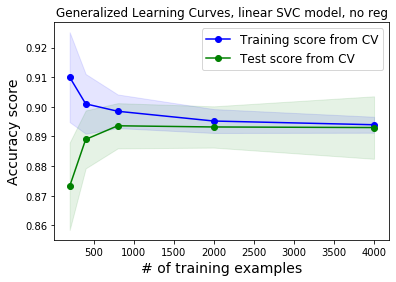

In [100]:
plot_learning_curve(piped_model, 'Generalized Learning Curves, linear SVC model, no reg', features_lim, target, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), cv = KFold(n_splits=5, shuffle=True))
#plt.savefig('LC_SVC.png')

### Conclusions??

Our classifier is behaving better than a random/lazy one.

Our model does not suffer from high variance, so for improvement we'd look at "high bias" fixes.

Having more data would not help.

<hr>

# Additional Material

What follows are some additional steps one can take 

<hr>

### Parameter optimization 

(note: this is NOT nested cross validation).

In [101]:
piped_model = make_pipeline(StandardScaler(), SVC()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

### We can define a grid of parameter values to run the optimization. 

(should do nested CV to estimate generalization error!)

Note that this might take a while (~15 mins on my laptop). 


In [102]:
#optimizing SVC: THIS IS NOT YET NESTED CV

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001,'scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svc__degree': [2, 4, 8]}

model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_lim,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/holwerda/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.8974 {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


#### Visualize the scores in a data frame, and rank them according to test scores.

I like to look at mean, std of test scores, mean of train scores (so I can evaluate if they differ and the significance of the result), and also fitting time (would pick a model that takes less time if scores are comparable).

In [103]:
scores_lim = pd.DataFrame(model.cv_results_)

scores_lim[['params','mean_test_score','std_test_score','mean_train_score', \
            'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
27,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8974,0.006530,0.92200,0.287296
35,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8974,0.006530,0.92200,0.256476
43,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8974,0.006530,0.92200,0.266570
47,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.8952,0.006969,0.93930,0.337528
31,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.8952,0.006969,0.93930,0.405240
39,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.8952,0.006969,0.93930,0.313435
53,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8940,0.005831,0.91230,0.223704
61,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8940,0.005831,0.91230,0.221043
69,"{'svc__C': 10.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8940,0.005831,0.91230,0.230655
37,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8930,0.005329,0.90035,0.255154


#### We can also isolate one type of kernel to look at it more closely.

In [104]:
scores_lim[scores_lim['param_svc__kernel'] == 'poly'][['params','mean_test_score','std_test_score',\
                        'mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
76,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.8766,0.004587,0.88465,0.344431
30,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8766,0.004587,0.88465,0.402299
26,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8756,0.005238,0.88225,0.269789
98,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8752,0.003763,0.88855,44.349694
102,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8752,0.003763,0.88860,149.216133
78,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8752,0.004534,0.88850,13.986900
50,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8750,0.004427,0.88630,0.649464
54,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8750,0.004336,0.88765,1.422418
100,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.8748,0.004445,0.88760,1.427218
74,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8746,0.004499,0.88840,4.376619


In [105]:
scores_lim.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_svc__C', 'param_svc__degree', 'param_svc__gamma',
       'param_svc__kernel', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

### Final diagnosis 

The problem here is high bias, which is not that surprising given that we are using only a subset of features.

We can try two things: making up new features which might help, based on what we know about the problem, and using an imputing strategy to include information about the discarded features.

### Define some new variables 

In [106]:
features = features.fillna(0) #takes care of nan

In [107]:
features = features.replace('', 0) #takes care of empty string values

In [108]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [109]:
np.unique(features.Type_1.values)

array(['b', 'j'], dtype=object)

Let's start by looking at what kind of particles we have as a product of the collision.

In [110]:
np.unique(np.array([features['Type_'+str(i)].values for i in range(1,14)]).astype('str'))

array(['0', 'b', 'e+', 'e-', 'g', 'j', 'm+', 'm-'], dtype='<U2')

Here are the proposed new features (justification can be found in the draft of this chapter posted on BB!)
    
    1. The total number of particles produced
    2. The total number of b jets
    3. The total number of jets
    4. The total number of leptons (electrons, positron, mu+, mu-)

In [111]:
#count number of non-zero types 

ntot = np.array([-(np.sum(np.array([features['Type_'+str(i)].values[j] == 0 for i in range(1,14)])) - 13) for j in range(features.shape[0])])

In [112]:
#define new column in my data frame

features['Total_products'] = ntot

In [113]:
#count number of b jets 

nbtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'b' for i in range(1,14)])) for j in range(features.shape[0])])

In [114]:
#define new column in my data frame

features['Total_b'] = nbtot

In [115]:
#Actually, let's count all types (jets, photons g, e-, e+, mu-, mu+)

njtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'j' for i in range(1,14)])) for j in range(features.shape[0])])

In [116]:
ngtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'g' for i in range(1,14)])) for j in range(features.shape[0])])

In [117]:
n_el_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e-' for i in range(1,14)])) for j in range(features.shape[0])])

In [118]:
n_pos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e+' for i in range(1,14)])) for j in range(features.shape[0])])

In [119]:
n_muneg_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm-' for i in range(1,14)])) for j in range(features.shape[0])])

In [120]:
n_mupos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm+' for i in range(1,14)])) for j in range(features.shape[0])])

In [121]:
n_lepton_tot = n_el_tot + n_pos_tot + n_muneg_tot + n_mupos_tot

And here we define the other new features:

In [122]:
features['Total_j'] = njtot
features['Total_g'] = ngtot
features['Total_leptons'] = n_lepton_tot

In [123]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52,Total_products,Total_b,Total_j,Total_g,Total_leptons
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,1,3,0,1
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,4,0,2,0,2
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,1,4,0,0
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,1,4,0,0
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,0,5,0,0


### Feature engineering 1: impact of ad-hoc variables

In [124]:
features_lim_2 = features[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16','Total_products', 'Total_b' ,'Total_j','Total_g', 
              'Total_leptons']]

In [125]:
bmodel #remember our benchmark model?

LinearSVC(C=1000, dual=False)

In [126]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 1000))

In [127]:
benchmark_lim2_piped = cross_validate(piped_model, features_lim_2, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [128]:
benchmark_lim2_piped

{'fit_time': array([0.01487422, 0.01343322, 0.01491094, 0.01343799, 0.01448703]),
 'score_time': array([0.00251698, 0.00246096, 0.00231719, 0.00265193, 0.00198317]),
 'test_score': array([0.952, 0.939, 0.961, 0.948, 0.94 ]),
 'train_score': array([0.95   , 0.9555 , 0.94825, 0.95   , 0.95   ])}

In [129]:
np.round(benchmark_lim2_piped['test_score'].mean(),3), np.round(benchmark_lim2_piped['test_score'].std(), 3)

(0.948, 0.008)

In [130]:
piped_model = make_pipeline(StandardScaler(), SVC())

In [131]:
#optimizing SVC: Takes a while (~ 15 mins!)

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001,'scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0], 'svc__degree': [2, 4, 8]}

nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_lim_2,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params, best score: 0.9466 {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [132]:
scores_lim_2 = pd.DataFrame(model.cv_results_)
scores_lim_2[['params','mean_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

,params,mean_test_score,mean_train_score,mean_fit_time
45,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9466,0.95325,0.140002
37,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9466,0.95325,0.144994
29,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9466,0.95325,0.138412
27,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9446,0.96605,0.174924
35,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9446,0.96605,0.202948
43,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9446,0.96605,0.175684
89,"{'svc__C': 100.0, 'svc__degree': 8, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9430,0.94530,0.175219
73,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9430,0.94530,0.174408
81,"{'svc__C': 100.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9430,0.94530,0.178710
53,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9428,0.96250,0.148301


### Another feature engineering attempt we could potentially do is use the type of product in the i-th location as a feature.

We could do it with label encoding, but this introduces a notion of distance metric (labels that are mapped to 0 and 1 are interpreted to be closer to each other than labels that are mapped into 0 and 7).

We introduce as many new columns as categorical labels, and we just use a 0/1 to indicate that the particle is of that type.

In [133]:
features_add = pd.get_dummies(data=features, columns=['Type_'+str(i) for i in range(1,14)])

In [134]:
features_add.columns[58:80]

Index(['Total_leptons', 'Type_1_b', 'Type_1_j', 'Type_2_0', 'Type_2_b',
       'Type_2_e+', 'Type_2_e-', 'Type_2_g', 'Type_2_j', 'Type_2_m+',
       'Type_2_m-', 'Type_3_0', 'Type_3_b', 'Type_3_e+', 'Type_3_e-',
       'Type_3_g', 'Type_3_j', 'Type_3_m+', 'Type_3_m-', 'Type_4_0',
       'Type_4_b', 'Type_4_e+'],
      dtype='object')

In [135]:
features_add.shape

(5000, 156)

### Feature engineering 2: add other variables (type of product)

In [136]:
features_lim_3 = features_add[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16','Total_products', 'Total_b' ,'Total_j','Total_g', 
              'Total_leptons','Type_1_b',
       'Type_1_j', 'Type_2_0', 'Type_2_b', 'Type_2_e+', 'Type_2_e-',
       'Type_2_g', 'Type_2_j', 'Type_2_m+', 'Type_2_m-', 'Type_3_0',
       'Type_3_b', 'Type_3_e+', 'Type_3_e-', 'Type_3_g', 'Type_3_j',
       'Type_3_m+', 'Type_3_m-', 'Type_4_0', 'Type_4_b', 'Type_4_e+',
       'Type_4_e-', 'Type_4_g', 'Type_4_j', 'Type_4_m+', 'Type_4_m-']]

In [137]:
features_lim_3.head()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,Total_products,Total_b,Total_j,Total_g,Total_leptons,Type_1_b,Type_1_j,Type_2_0,Type_2_b,Type_2_e+,Type_2_e-,Type_2_g,Type_2_j,Type_2_m+,Type_2_m-,Type_3_0,Type_3_b,Type_3_e+,Type_3_e-,Type_3_g,Type_3_j,Type_3_m+,Type_3_m-,Type_4_0,Type_4_b,Type_4_e+,Type_4_e-,Type_4_g,Type_4_j,Type_4_m+,Type_4_m-
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,137571.0,128444.0,-0.345744,-0.307112,174209.0,127932.0,0.826569,2.332000,86788.9,84554.9,-0.180795,2.187970,140289.0,76955.8,-1.19933,-1.302800,5,1,3,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,57594.2,-0.509253,161529.0,80458.3,-1.318010,1.402050,291490.0,68462.9,-2.126740,-2.582310,44270.1,35139.6,-0.706120,-0.371392,72883.9,26902.2,-1.65386,-3.129630,4,0,2,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,82313.3,1.686840,167130.0,113078.0,0.937258,-2.068680,102423.0,54922.3,1.226850,0.646589,60768.9,36244.3,1.102890,-1.434480,77714.0,27801.5,1.68461,1.389690,5,1,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,30610.8,2.617120,112267.0,61383.9,-1.211050,-1.457800,40647.8,39472.0,-0.024646,-2.222800,201589.0,32978.6,-2.496040,1.137810,90096.7,26964.5,1.87132,0.817631,5,1,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,45153.1,-2.241350,178174.0,100164.0,1.166880,-0.018721,92351.3,69762.1,0.774114,2.568740,61625.2,50086.7,0.652572,-3.012800,104193.0,31151.0,1.87641,0.865381,5,0,5,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [138]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 10**3))

In [139]:
benchmark = cross_validate(piped_model, features_lim_3, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [140]:
benchmark

{'fit_time': array([0.02472401, 0.02209496, 0.02652621, 0.02209306, 0.02719498]),
 'score_time': array([0.00232291, 0.00311708, 0.00229907, 0.00234985, 0.00232601]),
 'test_score': array([0.953, 0.937, 0.959, 0.949, 0.942]),
 'train_score': array([0.95075, 0.955  , 0.947  , 0.951  , 0.952  ])}

In [141]:
np.round(benchmark['test_score'].mean(),3), np.round(benchmark['test_score'].std(), 3)

(0.948, 0.008)

In [142]:
np.round(benchmark['train_score'].mean(),3), np.round(benchmark['train_score'].std(), 3)

(0.951, 0.003)

#### No further improvement is observed, although we should optimize the model.

In [143]:
piped_model = make_pipeline(StandardScaler(), SVC())

In [144]:
#optimizing SVC: 

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001,'scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0, 1000.0], 'svc__degree': [4]} #poly never helps
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_lim_3,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

scores_lim_3 = pd.DataFrame(model.cv_results_)
scores_lim_3[['params','mean_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/holwerda/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.9484 {'svc__C': 1000.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}


,params,mean_test_score,mean_train_score,mean_fit_time
33,"{'svc__C': 1000.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9484,0.95035,0.165288
13,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9458,0.95520,0.185590
11,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9452,0.96185,0.219735
25,"{'svc__C': 100.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9428,0.94475,0.208184
21,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9416,0.96990,0.195404
5,"{'svc__C': 0.1, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9388,0.94155,0.252313
19,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9384,0.98455,0.238231
3,"{'svc__C': 0.1, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9364,0.94130,0.271426
18,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.9302,0.97580,0.284554
28,"{'svc__C': 100.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.9290,0.96785,0.287051


### Finally, we can try with all the features

In [145]:
features_add.shape

(5000, 156)

In [146]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 1000))

In [147]:
cv

StratifiedKFold(n_splits=5, random_state=101, shuffle=True)

In [148]:
benchmark = cross_validate(piped_model, features_add, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [149]:
benchmark

{'fit_time': array([0.36746812, 2.49877906, 1.58527184, 0.36305499, 0.13000774]),
 'score_time': array([0.00379109, 0.00378895, 0.00351906, 0.00317597, 0.00326705]),
 'test_score': array([0.94 , 0.93 , 0.956, 0.929, 0.929]),
 'train_score': array([0.95275, 0.957  , 0.949  , 0.95675, 0.956  ])}

In [150]:
np.round(benchmark['test_score'].mean(),3), np.round(benchmark['test_score'].std(), 3)

(0.937, 0.01)

In [151]:
np.round(benchmark['train_score'].mean(),3), np.round(benchmark['train_score'].std(), 3)

(0.954, 0.003)

### Interesting: the model with all features has higher variance.

In [152]:
piped_model = make_pipeline(StandardScaler(), SVC())

In [153]:
#optimizing SVC: THIS IS NOT YET NESTED CV

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001, 0.001, 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 1000.0], 'svc__degree': [4]} #poly never helps
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_add,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/holwerda/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.9418 {'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [154]:
scores_all = pd.DataFrame(model.cv_results_)
scores_all[['params','mean_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

,params,mean_test_score,mean_train_score,mean_fit_time
11,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}",0.9418,0.95145,0.633941
25,"{'svc__C': 1000.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9414,0.95540,0.487288
19,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}",0.9406,0.96725,0.582399
13,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9378,0.97645,1.065782
21,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9316,0.99745,1.042641
29,"{'svc__C': 1000.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9298,1.00000,1.006388
17,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9246,0.92620,0.723848
12,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.9238,0.97950,1.111250
5,"{'svc__C': 0.1, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9230,0.94440,1.015942
3,"{'svc__C': 0.1, 'svc__degree': 4, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}",0.9210,0.92220,0.828480


## Morale of the story: feature engineering often works best if we use subject matter knowledge, and more features is not necessarily better!